# KDE Dataset Generation

*Version 1.0.0*

## Purpose

The purpose of this prioject is to generate a new dataset from a original dataset. The new dataset can be smaller and/or bigger than the original. Also, the new dataset also must be equivalent to the original which means that it must keep the same information.

We will believe that the dataset "essence" is contained in attribute and category distributions so we will estimate `Probabily Density Functions` (`PDFs`) from the original dataset using `Kernel Density Estimation` (`KDE`). The new dataset will be built from the original `PDFs`.

## Test Dataset Generation

We will build a custom dataset to simplify the analysis, development and testing.

We need a dataset with only one attribute and two categories. Besides, the category distributions must show a little overlap between them.

We will generate a test dataset with 200 instances (100 instances per category).

Finally, we will plot the dataset distribution (attribute) per category.

Figure 1: Dataset distribution by category


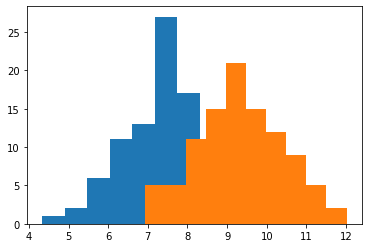

In [1]:
from kde_dataset_generator import dataset

# Dataset params
size = 200
n_categories = 2
seed = 8

# Generate df
df = dataset.generate_univariate_dataset(size, n_categories, seed)

# Plot df
print("Figure 1: Dataset distribution by category")
dataset.plot_univariate(df)


Looking at the chart we can conclude that the test dataset was generated correclty. Even we can see the little overlap.

## KDEs

We need to get the `KDEs` from the dataset distributions to estimate `PDFs`.

We will always generate as many `KDEs` as there are categories. We will take instances associated to a specific category and build the `KDE` from them. Each instance will keep all attributes. That means `KDEs` are multidimensional (one dimension per attribute).

For this case, we will calculate two `KDEs` (1 for category `0`, 1 for category `1`).

In [2]:
from kde_dataset_generator import kde 

# Caculate KDEs
kdes, ranges = kde.calculate_kdes(df)

To make sure `PDFs` estimation are right, we will plot category distributions using the previous calculated `KDEs`.

Figure 2: Dataset distributions by category using KDEs


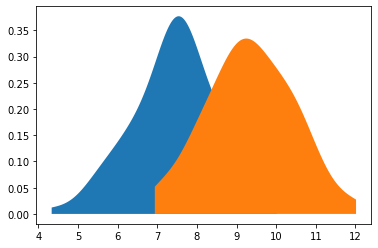

In [3]:
print("Figure 2: Dataset distributions by category using KDEs")
kde.plot_univariate(df, kdes)

The distributions represented in charts are the same, so we concludes that `KDEs` are right.

## First method

To generate the new dataset this method will generate instances randomly and label the new instances using previous `KDEs`.

The possible attribute values of each instance must be contained in attribute intervals (one interval per attribute) which have been calculated from original attribute values.

Once a new instance is generated we will estimate its density using each `KDE`. We will set the label associated to the `KDE` that gives biggest density. We will repeat this process until reach the amount of instances per category which have been defined previously. Instances associate to a category which is full will be discard.

The minimun amount of instances per category is a parameter which depends of the dataset. To optimize this parameter we will need an another study. We will test with different values until getting enough instances to describe correctly each category distribution. We will check it comparing the charts.

We are going to define attribute intervals.

In [4]:
# Get attribute intervals
attribute_intervals = dataset.attribute_intervals(df)

We are going to generate instances and label it until reach the target amount of new instances per category.

In [5]:
# Define amount of new instances per category
n_instances = 1000
# Build nw dataset
new_df = kde.random_generation(n_instances, kdes, attribute_intervals, df.columns, seed)

Now we will plot the new dataset distribution and compare it with the original dataset distribution.

Figure 3: New Dataset generated using first method


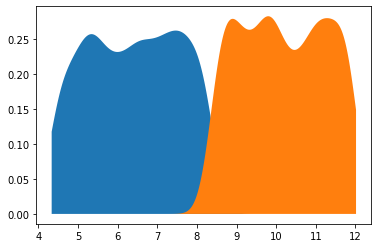

In [6]:
# Calculate new kdes of the new dataset
new_kdes = kde.calculate_kdes(new_df)[0]

# Plot new dataset
print("Figure 3: New Dataset generated using first method")
kde.plot_univariate(new_df, new_kdes, ranges)

The new dataset distribution is significantly different.

We can see that the random instances are well labeled. But if we compare each category distribution with the original category distribution we will see that is not the same.

The reason behind of these differences may be that all attribute values have the same probability of appearing but in distributions some values must have more propability of appearing than others.

The current version of this method does not converge.

## Second method

In this method, we will generate relevant instances for each category distribution, we will estimate density (relevancy) for each instance and we will build a dataset which each relevant instances is correctly represented.

We are going to generate each category distribution in a independant way. For each category distribution, we need to generate relevant instances which be called support. For each instance, we will estimate density using the previous `KDEs`. This density determines which instances are more significant for original category distribution so we will build a dataset which more relevant instances will be more represented. To achieve this we will introduce more occurrences of more important instances.

There are different ways to generate the support. This topic would require a study to find an efficient method.

We are going to use an exhaustive method which consist in generaing instances to cover all category distribution space. For example, in our test dataset, the attribute interval for category one is [7,12] so we will generate equally spaced instances between 7 and 12.

The support adjustment to original category distribution can be managed increasing or decreasing the amount of support instances. We will call granularity to this parameter. To optimize the granularity we will need a specify study.

To build the support in multivariate dataset cases we will generate each attribute support with the above method and do a cartesian product between all attribute support.

If we think about exahustive method in a practical way, we will take into account that this method has an unacceptable complexity. So we will need to design more efficient methods in the future.

We are going to generate the support.

In [7]:
# Define granularity
granularity = 100

# Generate supports
new_df = kde.univariate_support(df, granularity)

We are going to estimate density for each instance. We will use the original `KDEs` to achieve this. Each category KDE will be used with its category support instances.

In [8]:
# Calculate densities for each instance
densities = kde.estimate_density(new_df, kdes)

Now we know the density for each new instance. That means that we know the representation grade of each new instance relative to the original dataset. The goal is to modify the new dataset to get a correct representation for each instance.

There are multiple ways to change instance representations in the dataset.

We are going to increase the amount of the same instance using its density. That means instances with higher density will be appear more than instances with lower density. We will link to the instance with lowest density to an amount of one instance so to calculate the amount of duplicate instances for each instance we are going to divide the instance density between lowest density.

We can think that duplicates instances adding redundant information and so it is. But there is no problem because it is just a method of get the correct instance representations and granularity is managed by support parameter. Nevertheless, there are alternatives to fix instances represention which do not involve duplicate instances. For example, we can search instance neighbours and add them.

We are going to build the new dataset using the previous method.

In [9]:
# Adjust instance representations in the new dataset
new_df = kde.adjust_representation(densities)

Finally, we are going to plot new dataset and compare it with original dataset.

Figure 4: New dataset generated using second method


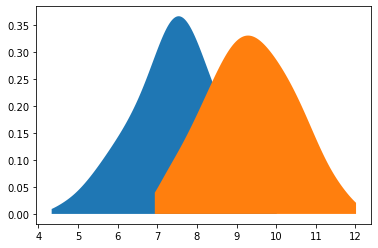

In [10]:
# Plot new df
print("Figure 4: New dataset generated using second method")
new_kdes = kde.calculate_kdes(new_df)[0]
kde.plot_univariate(new_df, new_kdes)

If we compare the new dataset distribution with the original dataset distribution, we will see that they are the same so we can conclude that this method converges.

The new dataset size is about 2000 instances. The instance amount has increased significantly but it is not very important. This result is to due to the support method and representation adjustment method used which can easily change for another methods which can reduce the number of instances. Even if we can not a method which give us a smaller dataset directly, we can design another `KDE` based method which can reduce dataset instances. For example, we can combine `KDE` with `MSE` to achieve this.

The most important part of the proposal method is that we can generate an equivalent dataset with different values compared to the original values.

## Future changes

The original purpose is generate an equivalent dataset from the original but with different values. For this, we will use `PDFs` which are estimated using `KDE`.

We are found a [book section](https://web.mit.edu/urban_or_book/www/book/chapter7/7.1.3.html) in which there are apparently at leat 4 methods to generate samples from a `PDF`. These methods would be able to more efficient than the second method so we will be interesting analyze them.